In [ ]:
!pip install pyannote.metrics
!pip install torchaudio

     |████████████████████████████████| 51kB 2.7MB/s 
     |████████████████████████████████| 61kB 4.1MB/s 
     |████████████████████████████████| 51kB 4.4MB/s 
     |████████████████████████████████| 133kB 8.7MB/s 
     |████████████████████████████████| 1.9MB 5.1MB/s 


In [ ]:
# load_data.py 
import numpy as np
import pandas as pd
import IPython.display as ipd
import soundfile as sf

%load_ext autoreload
%autoreload 2

# ! git clone https://github.com/yistLin/dvector.git
%cd dvector

from google.colab import drive
drive.mount('/content/drive')
DATA_BASE_DIR = "/content/drive/MyDrive"

[Errno 2] No such file or directory: 'dvector'
/content
Mounted at /content/drive


In [ ]:
import glob
from scipy.io import wavfile
from pyannote.database.util import load_rttm

class DataLoader():
    """docstring for DataLoader"""
    def __init__(self, audio_folder, labels_folder, names_only=False):
        # Audio files are assumed to have .wav extension,
        # Label files are assumed to have .rttm extension
        self.audio_files = sorted(glob.glob(audio_folder + "/*.wav"))
        self.label_files = sorted(glob.glob(labels_folder + "/*.rttm"))
        self.names_only = names_only

        assert len(self.audio_files) == len(self.label_files)
    

    def __len__(self):
        return len(self.label_files)


    def __getitem__(self, idx):
        # Extract labels from rttm file
        label_dict = load_rttm(self.label_files[idx])
        label = list(label_dict.values())
        label = label[0]

        if self.names_only:
          return (self.audio_files[idx], label)

        # Extract audio and sample rate from wav file
        samplerate, wav_data = wavfile.read(self.audio_files[idx])

        return ((samplerate, wav_data), label)
        
file_loader = DataLoader(audio_folder = f"{DATA_BASE_DIR}/voxconverse_dev_wav", labels_folder = f"{DATA_BASE_DIR}/voxconverse_dev_labels/dev", names_only=True)

## Trying to split

In [ ]:
## Mel-filterbank
mel_window_length = 25  # In milliseconds
mel_window_step = 10    # In milliseconds
mel_n_channels = 40

## Audio
sampling_rate = 16000
# Number of spectrogram frames in a partial utterance
partials_n_frames = 40     # 400 ms

In [ ]:
def compute_partial_slices(n_samples: int, rate, min_coverage):
        """
        Computes where to split an utterance waveform and its corresponding mel spectrogram to
        obtain partial utterances of <partials_n_frames> each. Both the waveform and the
        mel spectrogram slices are returned, so as to make each partial utterance waveform
        correspond to its spectrogram.
        The returned ranges may be indexing further than the length of the waveform. It is
        recommended that you pad the waveform with zeros up to wav_slices[-1].stop.
        :param n_samples: the number of samples in the waveform
        :param rate: how many partial utterances should occur per second. Partial utterances must
        cover the span of the entire utterance, thus the rate should not be lower than the inverse
        of the duration of a partial utterance. By default, partial utterances are 1.6s long and
        the minimum rate is thus 0.625.
        :param min_coverage: when reaching the last partial utterance, it may or may not have
        enough frames. If at least <min_pad_coverage> of <partials_n_frames> are present,
        then the last partial utterance will be considered by zero-padding the audio. Otherwise,
        it will be discarded. If there aren't enough frames for one partial utterance,
        this parameter is ignored so that the function always returns at least one slice.
        :return: the waveform slices and mel spectrogram slices as lists of array slices. Index
        respectively the waveform and the mel spectrogram with these slices to obtain the partial
        utterances.
        """
        assert 0 < min_coverage <= 1

        # Compute how many frames separate two partial utterances
        samples_per_frame = int((sampling_rate * mel_window_step / 1000))
        n_frames = int(np.ceil((n_samples + 1) / samples_per_frame))
        frame_step = int(np.round((sampling_rate / rate) / samples_per_frame))
        assert 0 < frame_step, "The rate is too high"
        assert frame_step <= partials_n_frames, "The rate is too low, it should be %f at least" % \
            (sampling_rate / (samples_per_frame * partials_n_frames))

        # Compute the slices
        wav_slices, mel_slices = [], []
        steps = max(1, n_frames - partials_n_frames + frame_step + 1)
        for i in range(0, steps, frame_step):
            mel_range = np.array([i, i + partials_n_frames])
            wav_range = mel_range * samples_per_frame
            mel_slices.append(slice(*mel_range))
            wav_slices.append(slice(*wav_range))

        # Evaluate whether extra padding is warranted or not
        last_wav_range = wav_slices[-1]
        coverage = (n_samples - last_wav_range.start) / (last_wav_range.stop - last_wav_range.start)
        if coverage < min_coverage and len(mel_slices) > 1:
            mel_slices = mel_slices[:-1]
            wav_slices = wav_slices[:-1]

        return wav_slices, mel_slices

In [ ]:
import torch
import torchaudio

wav2mel = torch.jit.load("wav2mel.pt")
dvector = torch.jit.load("dvector.pt").eval()

wav_file_name, reference = file_loader[1]
wav_tensor, sample_rate = torchaudio.load(wav_file_name)
mel_tensor = wav2mel(wav_tensor, sample_rate)  # shape: (frames, mel_dim)
emb_tensor = dvector.embed_utterance(mel_tensor)  # shape: (emb_dim)

In [ ]:
print(mel_tensor.shape)
print(emb_tensor.shape)

torch.Size([10201, 40])
torch.Size([256])


## Loading model

In [ ]:
% cd /content

/content


In [ ]:
import torch
import torchaudio

# from data.wav2mel import Wav2Mel
torchaudio.set_audio_backend("sox_io")

# wav2mel = Wav2Mel()
# wav2mel = torch.jit.script(wav2mel)
# wav2mel.save("wav2mel.pt")
# wav2mel = torch.jit.load("log_melspectrogram.pt")
dvector = torch.jit.load("dvector.pt").eval()

# audio_file_name, reference = file_loader[1]

# wav_tensor, sample_rate = torchaudio.load(audio_file_name)
# mel_tensor = wav2mel(wav_tensor, sample_rate)  # shape: (frames, mel_dim)
# emb_tensor = dvector.embed_utterance(mel_tensor)  # shape: (emb_dim)a
# emb_tensor.shape

In [ ]:
# wav_tensor.shape, mel_tensor.shape, emb_tensor.shape

In [ ]:
import os
if os.path.exists("/content/Speaker-Diarization-System"):
   % cd /content/Speaker-Diarization-System
   ! git pull 
else:
  % cd /content
  ! git clone https://gitlab.com/vaithak/Speaker-Diarization-System.git
  % cd /content/Speaker-Diarization-System

!pip install -r requirements.txt

/content/Speaker-Diarization-System
Already up to date.
     |████████████████████████████████| 15.7MB 254kB/s 
     |████████████████████████████████| 81kB 8.2MB/s 
     |████████████████████████████████| 71kB 6.8MB/s 
  Created wheel for typing: filename=typing-3.7.4.3-cp37-none-any.whl size=26308 sha256=e1895b732b00493d7c1529c501589bbcb8fa5a670fceed91c0eb0dc5c6674698
  Stored in directory: /root/.cache/pip/wheels/2d/04/41/8e1836e79581989c22eebac3f4e70aaac9af07b0908da173be
  Created wheel for webrtcvad: filename=webrtcvad-2.0.10-cp37-cp37m-linux_x86_64.whl size=72295 sha256=e5172e95daec0131758c3346c60407df183710942c1cc1a5183604d97b4671e6
  Stored in directory: /root/.cache/pip/wheels/44/2a/18/bd1aec41cac7c3051fe95d92a6ed446122ea31dc713c432fa1
Successfully built typing webrtcvad


In [ ]:
ls

Clustering/  Embedding/  __init__.py  model.model     README.md         Utils/
config/      hparam.py   LICENSE      Preprocessing/  requirements.txt


In [ ]:
# !pip install resemblyzer
# !pip install spectralcluster
from Utils import DataLoader
from Preprocessing import VAD_chunk
from Clustering import SpectralClustering
from Embedding import concat_segs, get_STFTs, align_embeddings, SpeechEmbedder
import torch

In [ ]:
def create_labelling(labels, continuos_times, seg_length_ms = 0.4):
    labelling = []
    
    time_idx = 0
    start_time = continuos_times[0][0]
    end_time = start_time + seg_length_ms

    for i in range(len(labels)):
        if end_time >= continuos_times[time_idx][1]:
            temp = [str(labels[i]), start_time, continuos_times[time_idx][1]]
            labelling.append(tuple(temp))
            time_idx += 1
            start_time = continuos_times[time_idx][0]
            end_time = start_time + seg_length_ms

        elif i==len(labels)-1:
            temp = [str(labels[i]), start_time, end_time]
            labelling.append(tuple(temp))

        elif labels[i] != labels[i+1]:
            temp = [str(labels[i]), start_time, end_time]
            labelling.append(tuple(temp))
            start_time = end_time
            end_time = start_time + seg_length_ms

        else:
            end_time += seg_length_ms

    return labelling

In [ ]:
# from sklearn.cluster import SpectralClustering, KMeans
from Clustering import SpectralClustering

def get_hypothesis(audio_file_name, embedder_net):
  times, segs = VAD_chunk(2, audio_file_name)
  concat_seg, continuos_times = concat_segs(times, segs)
  
  STFT_frames = get_STFTs(concat_seg)
  STFT_frames = np.stack(STFT_frames, axis=2)
  STFT_frames = torch.tensor(np.transpose(STFT_frames, axes=(2,1,0)))
  print(STFT_frames.shape)
  embeddings = []
  for STFT_frame in STFT_frames:
    embeddings.append((dvector.embed_utterance(STFT_frame.reshape(-1,40))).detach().numpy())
  print(len(embeddings), embeddings[0].shape)
  # embeddings = torch.tensor(embeddings)
  # embeddings = embedder_net(STFT_frames)
  aligned_embeddings = align_embeddings(embeddings)

  # Ger cluster ids for embedding
  clusterer = SpectralClustering(
    min_clusters=4,
    max_clusters=20,
    p_percentile=0.90,
    gaussian_blur_sigma=1
  )
  # labels = clusterer.predict(aligned_embeddings)
  labels = clusterer.predict(aligned_embeddings)

  # Get labelling from cluster assignment
  labelling = create_labelling(labels, continuos_times)
  return labelling, labels, aligned_embeddings

In [ ]:
(wav_data), reference = file_loader[2]
labelling, labels, embeddings = get_hypothesis(wav_data, 16000)

torch.Size([5513, 24, 40])
5513 (256,)


In [ ]:
len(labelling), len(labels), len(embeddings)

(368, 1651, 1651)

In [ ]:
from __future__ import print_function
import time
import numpy as np
import pandas as pd
# from sklearn.datasets import fetch_mldata
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
%matplotlib inline
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns

tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
tsne_results = tsne.fit_transform(embeddings)

df = pd.DataFrame(tsne_results, columns = {"one", "two"})
df["y"] = (labels)
df.head()

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 1651 samples in 0.032s...
[t-SNE] Computed neighbors for 1651 samples in 1.532s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1651
[t-SNE] Computed conditional probabilities for sample 1651 / 1651
[t-SNE] Mean sigma: 0.184096
[t-SNE] KL divergence after 250 iterations with early exaggeration: 69.869026
[t-SNE] KL divergence after 300 iterations: 1.771355


,two,one,y
0,5.514346,-3.630972,2
1,14.042770,6.848162,2
2,9.613286,-3.144570,2
3,11.382989,-5.070907,2
4,6.550267,-5.768169,2


In [ ]:
np.unique(labels)

array([0, 1, 2, 3], dtype=int32)

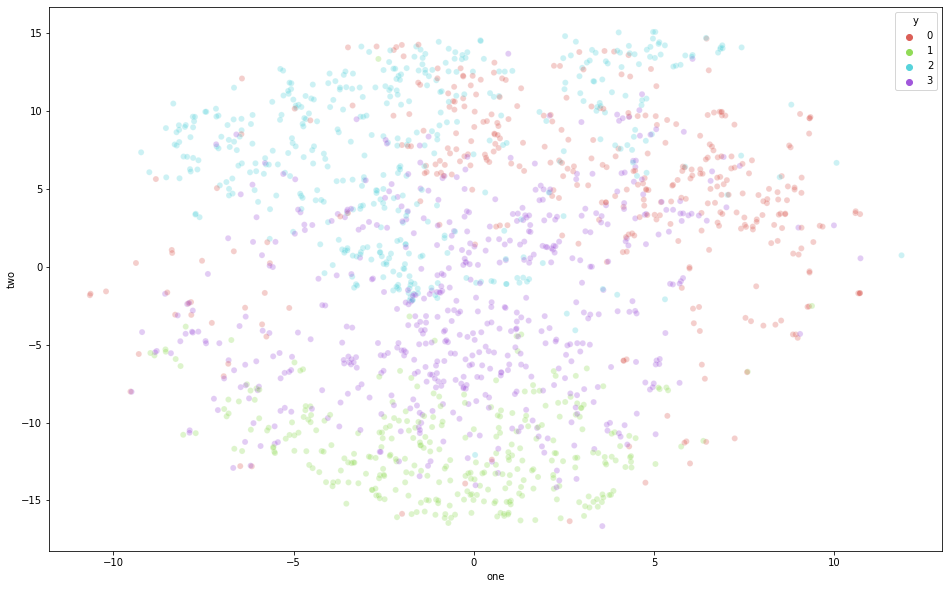

In [ ]:
# df_subset['tsne-2d-one'] = tsne_results[:,0]
# df_subset['tsne-2d-two'] = tsne_results[:,1]

plt.figure(figsize=(16,10))
sns.scatterplot(
    x="one", y="two",
    hue="y",
    palette=sns.color_palette("hls", len(np.unique(labels))),
    data=df,
    legend="full",
    alpha=0.3
)

In [ ]:
from pyannote.core import Segment, Timeline, Annotation
from pyannote.metrics.diarization import DiarizationErrorRate
import webrtcvad
import warnings
def Annotation_from_tuple_arr(labels_arr):
  annotate = Annotation()
  for label in labels_arr:
    annotate[Segment(label[1], label[2])] = str(int(label[0]))
  return annotate

hypothesis = Annotation_from_tuple_arr(labelling)
metric = DiarizationErrorRate()
abs(metric(reference, hypothesis))

/usr/local/lib/python3.7/dist-packages/pyannote/metrics/utils.py:184: UserWarning: 'uem' was approximated by the union of 'reference' and 'hypothesis' extents.
  "'uem' was approximated by the union of 'reference' "


0.511478674558818

In [ ]:
print(reference)

[ 00:00:00.040 -->  00:00:19.040] 39 spk03
[ 00:00:19.040 -->  00:00:19.520] 2 spk01
[ 00:00:20.440 -->  00:00:34.800] 40 spk03
[ 00:00:34.840 -->  00:01:04.840] 3 spk01
[ 00:01:04.840 -->  00:01:05.640] 41 spk03
[ 00:01:05.440 -->  00:01:07.840] 4 spk01
[ 00:01:07.480 -->  00:01:11.760] 42 spk03
[ 00:01:08.800 -->  00:01:10.720] 5 spk01
[ 00:01:11.720 -->  00:01:44.400] 6 spk01
[ 00:01:22.480 -->  00:01:22.920] 43 spk03
[ 00:01:30.160 -->  00:01:32.160] 45 spk03
[ 00:01:32.920 -->  00:01:33.360] 46 spk03
[ 00:01:43.520 -->  00:02:12.440] 47 spk03
[ 00:02:12.320 -->  00:02:27.320] 16 spk02
[ 00:02:20.120 -->  00:02:21.320] 48 spk03
[ 00:02:27.000 -->  00:02:34.160] 49 spk03
[ 00:02:34.320 -->  00:02:53.680] 17 spk02
[ 00:02:52.040 -->  00:03:03.040] 50 spk03
[ 00:02:57.480 -->  00:02:59.000] 18 spk02
[ 00:02:59.640 -->  00:03:00.440] 19 spk02
[ 00:03:02.520 -->  00:03:17.800] 20 spk02
[ 00:03:17.200 -->  00:03:21.520] 51 spk03
[ 00:03:20.560 -->  00:03:34.200] 21 spk02
[ 00:03:32.320 -

In [ ]:
print(hypothesis)

[ 00:00:00.140 -->  00:00:03.740] _ 0
[ 00:00:03.740 -->  00:00:03.880] _ 1
[ 00:00:05.220 -->  00:00:08.820] _ 1
[ 00:00:08.820 -->  00:00:12.520] _ 3
[ 00:00:12.660 -->  00:00:13.860] _ 3
[ 00:00:13.860 -->  00:00:14.660] _ 1
[ 00:00:14.660 -->  00:00:15.060] _ 2
[ 00:00:15.060 -->  00:00:18.660] _ 3
[ 00:00:18.660 -->  00:00:19.060] _ 2
[ 00:00:19.060 -->  00:00:21.420] _ 3
[ 00:00:21.440 -->  00:00:25.040] _ 3
[ 00:00:25.040 -->  00:00:25.060] _ 2
[ 00:00:25.180 -->  00:00:25.980] _ 1
[ 00:00:25.980 -->  00:00:29.640] _ 3
[ 00:00:29.800 -->  00:00:31.800] _ 3
[ 00:00:31.840 -->  00:00:33.440] _ 1
[ 00:00:33.440 -->  00:00:34.400] _ 3
[ 00:00:34.700 -->  00:00:35.900] _ 3
[ 00:00:35.900 -->  00:00:37.500] _ 2
[ 00:00:37.500 -->  00:00:38.300] _ 1
[ 00:00:38.300 -->  00:00:39.920] _ 2
[ 00:00:40.420 -->  00:00:40.820] _ 2
[ 00:00:40.820 -->  00:00:41.080] _ 1
[ 00:00:41.100 -->  00:00:43.900] _ 1
[ 00:00:43.900 -->  00:00:45.100] _ 2
[ 00:00:45.100 -->  00:00:45.520] _ 1
[ 00:00:45.6